In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim
from torch import autograd
import torch.nn.functional as F


from train_utils import get_capacity, plot_weights_hist, train
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         get_pred_index, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from models_utils import init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         adjust_learning_rate, \
                         compute_joint_probabilities, \
                         tsne_loss,\
                         tsne_criterion

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset

from pynndescent import NNDescent
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample
from sklearn.utils import check_random_state

%autoreload 2

In [2]:
# SCALER = MinMaxScaler((-1,1))
SCALER = StandardScaler()

input_parameters = {'generator': make_swiss_roll, #make_s_curve, 
                    'generator_kwargs': {'n_samples':1000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':True,
                    'scaler':SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, outpt, color = create_data()
inpt_test, outpt_test, color_test = create_data()

In [3]:
inpt_torch = torch.tensor(inpt, dtype=torch.float).to(device)
inpt_torch_test = torch.tensor(inpt_test, dtype=torch.float).to(device)

In [4]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [93]:
# X = inpt.T.copy()

# # number of trees in random projection forest
# n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
# # max number of nearest neighbor iters to perform
# n_iters = max(5, int(round(np.log2(X.shape[0]))))
# # distance metric
# metric="euclidean"
# # number of neighbors for computing k-neighbor graph
# n_neighbors = 10

# nnd = NNDescent(
#     X,
#     n_neighbors=n_neighbors,
#     metric=metric,
#     n_trees=n_trees,
#     n_iters=n_iters,
#     max_candidates=60,
#     verbose=True,
#     n_jobs=-1
# )
# # get indices and distances
# knn_indices, knn_dists = nnd.neighbor_graph

In [94]:
# # get indices and distances
# knn_indices, knn_dists = nnd.neighbor_graph
# random_state = check_random_state(None)
# # build fuzzy_simplicial_set
# out = fuzzy_simplicial_set(
#     X = X,
#     n_neighbors = n_neighbors,
#     metric = metric,
#     random_state = random_state,
#     knn_indices= knn_indices,
#     knn_dists = knn_dists,
#     return_dists=True
# )

In [95]:
# (out[-1].toarray() == out[-1].toarray().T).all()

# Train

In [96]:
class Encoder(nn.Module):

    def __init__ (self, input_dim, output_dim=2):
        super().__init__()
        self.linear1 = nn.Linear(3, 20)
        self.linear2 = nn.Linear(20, 50)
        self.linear3 = nn.Linear(50, 10)
        self.linear4 = nn.Linear(10, output_dim)

    def forward(self, x):
        
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = self.linear4(x)

        return x
    
model = Encoder(input_dim=3, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [97]:
# construct graph of nearest neighbors

X = inpt.T
graph_constructor =  ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=15,
                                        batch_size=1000, 
                                        random_state=42)

epochs_per_sample, head, tail, weight = graph_constructor(X)

dataset = UMAPDataset(X, epochs_per_sample, head, tail, weight, device=device, batch_size=1000)

criterion = UMAPLoss(device=device, 
                     min_dist=0.1,
                     batch_size=1000,
                     negative_sample_rate=5,
                     edge_weight=None,
                     repulsion_strength=1.0)

Thu Jul  7 20:33:44 2022 Building RP forest with 7 trees
Thu Jul  7 20:33:44 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations


In [98]:
train_losses = []
for epoch in tqdm(range(100)):
    train_loss = 0.
    for batch in dataset.get_batches():
        
        batch = batch.to(device)
        
        optimizer.zero_grad()
        embedding = model(batch)
        
        loss = criterion(embedding)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss)
#     print('epoch: {}, loss: {}'.format(epoch, train_loss))
    
clear_output()

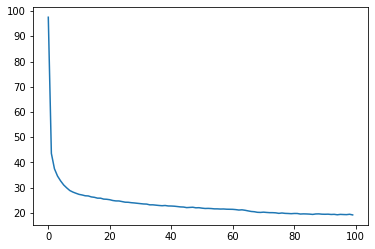

In [99]:
plt.plot(train_losses)

In [100]:
output_pred = to_numpy(model(inpt_torch_test.T))

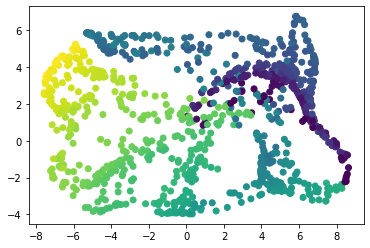

In [101]:
plt.scatter(output_pred[:,0], output_pred[:,1], c=color_test)

In [102]:
Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test.T, output_pred)
Q_loc_val_NET, Q_glob_val_NET

(0.5325457291271525, 0.6554700050441773)